In [2]:
import pandas as pd
import tensorflow as tf

DATA_PATH = '/home/kshipra/work/major/ml experiments/data/manually_combined.xlsx'

eos = pd.read_excel(DATA_PATH, sheet_name='all_stacked_eos')
sentinel = pd.read_excel(DATA_PATH, sheet_name='all_stacked_sentinel')
combined = pd.read_excel(DATA_PATH, sheet_name='eos_sent_combined')

len(eos), len(sentinel), len(combined)

(747, 796, 747)

In [3]:
X_cols = ['VH', 'VV', 'HH', 'HV', 'Angle']
y_col = ['SM (Combined)']

num_features = len(X_cols)

In [4]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_features, )), # Dynamic input shape
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(1)
])

In [5]:
from  model_experiments import PredictionIntervalEstimation

seed = 1337

exp = PredictionIntervalEstimation(
    combined,
    features=X_cols,
    target=y_col[0],
    satellite='EOS+Sentinel',
    random_state=seed
)

y_lower_test, y_upper_test, y_lower_val, y_upper_val = exp.train_model(
    model,
    learning_rate=0.0005, # Using the optimal LR from previous tuning
    epochs=1000,
    verbose=0 # Suppress epoch-by-epoch output
)

Epochs:  18%|█▊        | 178/1000 [00:15<01:12, 11.27epoch/s, loss=0.4398, val_loss=0.4621]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [6]:
metrics = exp.evaluate_model(exp.y_val, y_lower_val, y_upper_val)

metrics

{'PICP': np.float64(0.9523809523809523), 'MPIW': np.float32(32.422287)}

In [7]:
y_lower_test.shape, y_upper_test.shape, y_lower_val.shape, y_upper_val.shape

((75,), (75,), (168,), (168,))

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


/home/kshipra/work/major/ml experiments/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step


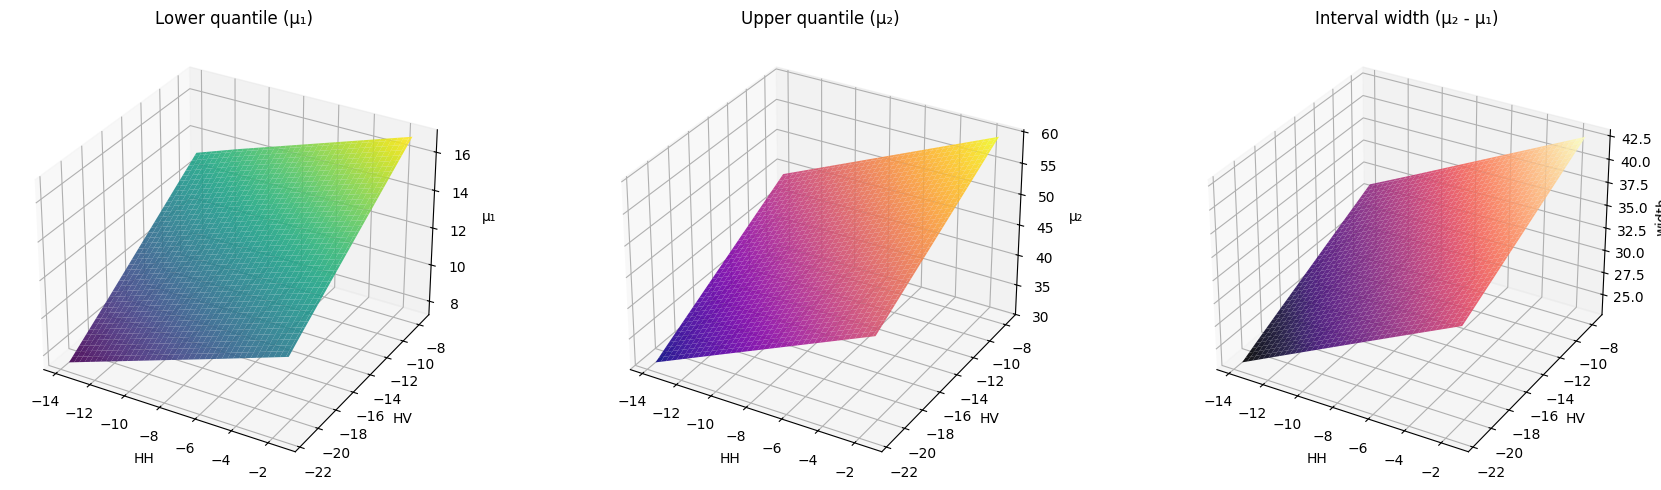

In [9]:
# required imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

# ---------- PARAMETERS you can tweak ----------
hh_col = 'HH'
hv_col = 'HV'
n_grid = 80          # grid resolution (80x80 -> 6400 forward passes)
save_path = 'loss_landscape.png'
# ------------------------------------------------

# sanity checks
if not hasattr(exp, 'lower_model') or not hasattr(exp, 'upper_model'):
    raise RuntimeError("exp.lower_model / exp.upper_model not found. Run exp.train_model(...) first.")

# get data ranges from the original dataframe used to create exp
df = exp.data  # inherited from ANNExperimentsV1
hh_min, hh_max = df[hh_col].min(), df[hh_col].max()
hv_min, hv_max = df[hv_col].min(), df[hv_col].max()

# build grid over HH (x) and HV (y)
hh_vals = np.linspace(hh_min, hh_max, n_grid)
hv_vals = np.linspace(hv_min, hv_max, n_grid)
HH, HV = np.meshgrid(hh_vals, hv_vals)

# prepare other features: fix to the train-set mean (or change to median)
feature_names = exp.features  # should be ['VH','VV','HH','HV','Angle']
fixed_row = {}
for f in feature_names:
    fixed_row[f] = df[f].mean()

# create full feature matrix for grid points
num_points = HH.size
X_grid = np.zeros((num_points, len(feature_names)))
# fill with fixed values first
for j, fname in enumerate(feature_names):
    X_grid[:, j] = fixed_row[fname]

# overwrite HH and HV columns with the grid values
hh_idx = feature_names.index(hh_col)
hv_idx = feature_names.index(hv_col)
X_grid[:, hh_idx] = HH.ravel()
X_grid[:, hv_idx] = HV.ravel()

# scale using the scaler saved in exp (same scaling used in training)
X_grid_scaled = exp.scaler.transform(X_grid)

# predict with both models
mu_lower = exp.lower_model.predict(X_grid_scaled).flatten()
mu_upper = exp.upper_model.predict(X_grid_scaled).flatten()

# reshape back to grid for plotting
Z_lower = mu_lower.reshape(HH.shape)
Z_upper = mu_upper.reshape(HH.shape)
Z_width = (mu_upper - mu_lower).reshape(HH.shape)

# Plotting: three subplots (lower, upper, width)
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(HH, HV, Z_lower, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_title('Lower quantile (μ₁)')
ax1.set_xlabel(hh_col); ax1.set_ylabel(hv_col); ax1.set_zlabel('μ₁')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(HH, HV, Z_upper, cmap='plasma', edgecolor='none', alpha=0.9)
ax2.set_title('Upper quantile (μ₂)')
ax2.set_xlabel(hh_col); ax2.set_ylabel(hv_col); ax2.set_zlabel('μ₂')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(HH, HV, Z_width, cmap='magma', edgecolor='none', alpha=0.9)
ax3.set_title('Interval width (μ₂ - μ₁)')
ax3.set_xlabel(hh_col); ax3.set_ylabel(hv_col); ax3.set_zlabel('width')

plt.tight_layout()
plt.savefig("/home/kshipra/work/major/ml experiments/output/plots/loss_landscape.png", dpi=200, bbox_inches="tight")
plt.show()
